# Modeling and Evaluation - Predict House Price

## Objectives

* Fit and evaluate a regression model to predict a house sale price when the house features are known.

## Inputs
* outputs/datasets/collection/housing_data_cleaned.csv

## Outputs 
* Train set: outputs/predict_price/v1/X_train.csv
* Test set: outputs/predict_price/v1/X_test.csv
* ML pipeline to predict house sale prices: outputs/predict_price/v1/best_pipeline.pkl



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-ML-PROJECT/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-ML-PROJECT'

# Load Data

In [4]:
import pandas as pd
import numpy as np
df = (pd.read_csv("outputs/datasets/collection/housing_data_cleaned.csv"))
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,1.0,706.0,6.0,150.0,548.0,2.0,2003.0,...,8450.0,65.0,196.0,61.0,5,7,856.0,2003,2003,208500.0
1,1262.0,0.0,3.0,4.0,978.0,5.0,284.0,460.0,2.0,1976.0,...,9600.0,80.0,0.0,0.0,8,6,1262.0,1976,1976,181500.0
2,920.0,866.0,3.0,2.0,486.0,6.0,434.0,608.0,2.0,2001.0,...,11250.0,68.0,162.0,42.0,5,7,920.0,2001,2002,223500.0
3,961.0,0.0,3.0,1.0,216.0,5.0,540.0,642.0,1.0,1998.0,...,9550.0,60.0,0.0,35.0,5,7,756.0,1915,1970,140000.0
4,1145.0,0.0,4.0,3.0,655.0,6.0,490.0,836.0,2.0,2000.0,...,14260.0,84.0,350.0,84.0,5,8,1145.0,2000,2000,250000.0


## Create ML Pipeline

- **Import all necassary ML algorithms**

### Bring in the pipeline from the feature engineering notebook with feature scaling, feature selection and model added:

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(dic, vars_with_missing_data, model):
    
      pipeline = Pipeline([                         
            ('median_imputer',  MeanMedianImputer(imputation_method='median', variables=vars_with_missing_data)),
            
            ('corr_sel', SmartCorrelatedSelection(method="spearman", threshold=0.9, selection_method="variance")),
            
            ("feat_scaling", StandardScaler() ),

            ("feat_selection",  SelectFromModel(model) ),

            ("model", model ),
      ])

      return pipeline


- **Hyperparameter optimization**: Custom hyperparameter optimization to fit my model

In [7]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, dic, vars_with_missing_data, models, params):
        self.dic = dic
        self.vars_with_missing_data = vars_with_missing_data
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(dic, vars_with_missing_data, self.models[key],)

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(np.array(r).reshape(-1, 1))


            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches
        

## Split the data into Train and Test sets

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print('Train Set:', X_train.shape, y_train.shape, 'Test Set:', X_test.shape, y_test.shape)

Train Set: (1168, 21) (1168,) Test Set: (292, 21) (292,)


## Grid Search CV from Scikit Learn

Lets try 7 ML models to find the best one

In [9]:
models_quick_search = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LinearRegression": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [10]:
dic = {'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}, 'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}, 'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}, 'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}}
vars_with_missing_data = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea']     


# Train 5 models, 1 for each of 5 cross validations for each algorithm and the hyperparameters

In [11]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_

## Lets check the results

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.698893,0.802179,0.840517,0.052256
5,GradientBoostingRegressor,0.635656,0.758993,0.820849,0.064068
3,ExtraTreesRegressor,0.609099,0.753388,0.816806,0.074522
2,RandomForestRegressor,0.664235,0.739333,0.817394,0.059135
4,AdaBoostRegressor,0.620702,0.737092,0.782031,0.059293
6,XGBRegressor,0.487189,0.649391,0.77456,0.101015
1,DecisionTreeRegressor,0.486472,0.574891,0.669601,0.066312


## Use hyperparameter optimization on the top 4 models using hyperparameter combinations

In [13]:
models_search = {
    "LinearRegression": LinearRegression(),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_search = {
    "LinearRegression":{},
    "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
                                 'model__learning_rate':[0.1, 0.01, 0.001],
                                 'model__max_depth': [3,15, None],
                                 'model__min_samples_split': [2,50],
                                 'model__min_samples_leaf': [1,50],
                                 'model__max_leaf_nodes': [None,50],
    },
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                           'model__max_depth': [None, 3, 15],
                           'model__min_samples_split': [2, 50],
                           'model__min_samples_leaf': [1,50],
    },
    "RandomForestRegressor":{'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
    },
}

## Train our models with Grid Search CV

* Totalling 1625 models

In [15]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_search, params=params_search)

search.fit(X_train, y_train, scoring= 'r2', n_jobs=1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


## Lets check the results

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(50)

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,LinearRegression,0.698893,0.802179,0.840517,0.052256,NaN,NaN,NaN,NaN,NaN,NaN
244,ExtraTreesRegressor,0.744901,0.795937,0.829172,0.033079,NaN,15,NaN,1,50,100
220,ExtraTreesRegressor,0.744913,0.795771,0.828444,0.032885,NaN,None,NaN,1,50,100
246,ExtraTreesRegressor,0.745416,0.795543,0.827446,0.033094,NaN,15,NaN,1,50,150
222,ExtraTreesRegressor,0.745427,0.795504,0.827098,0.033022,NaN,None,NaN,1,50,150
221,ExtraTreesRegressor,0.736958,0.794975,0.828928,0.036013,NaN,None,NaN,1,50,50
245,ExtraTreesRegressor,0.736767,0.79494,0.828833,0.036128,NaN,15,NaN,1,50,50
9,GradientBoostingRegressor,0.732471,0.789388,0.821784,0.032403,0.1,3,None,50,2,140
12,GradientBoostingRegressor,0.732471,0.789388,0.821784,0.032403,0.1,3,None,50,50,140
24,GradientBoostingRegressor,0.732471,0.789388,0.821784,0.032403,0.1,3,50,50,50,140


### Now we will look into all 4 algorithms

## **1. ExtraTreesRegressor**

In [17]:
best_model = grid_search_summary.iloc[1,0]
best_model

'ExtraTreesRegressor'

* Best model parameters

In [18]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 100}

* Best model pipeline

In [19]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('median_imputer',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'BsmtFinType1', 'GarageFinish',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.9)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=15, min_samples_split=50,
                                     random_state=0))])

## Assess the Feature Importance

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'KitchenQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF']


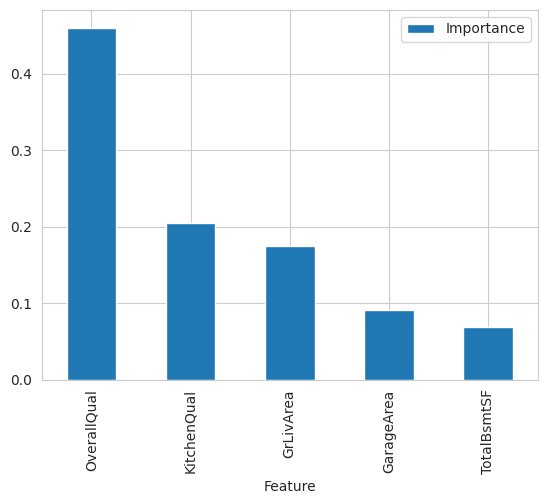

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Apply pipeline transformation to X_train
transformed_array = Pipeline(best_pipeline.steps[:4]).transform(X_train)

# Extract selected features correctly
selected_mask = best_pipeline['feat_selection'].get_support()
selected_features = [col for col, keep in zip(X_train.columns, selected_mask) if keep]

# Extract final selected features
best_features = selected_features

# Create DataFrame with selected feature importance
df_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the most important features
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot feature importance
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')

plt.show()


### Evaluate Train and Test Sets

In [21]:
# Following code is from a SKlearn lesson from Code Institute
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].tick_params(axis='x', rotation=90)
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].tick_params(axis='x', rotation=90)
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

plt.show()

### Evaluate Model Performance

Model Evaluation 

* Train Set
R2 Score: 0.844
Mean Absolute Error: 19794.401
Mean Squared Error: 960126799.427
Root Mean Squared Error: 30985.913


* Test Set
R2 Score: 0.771
Mean Absolute Error: 22437.446
Mean Squared Error: 1582271822.126
Root Mean Squared Error: 39777.781




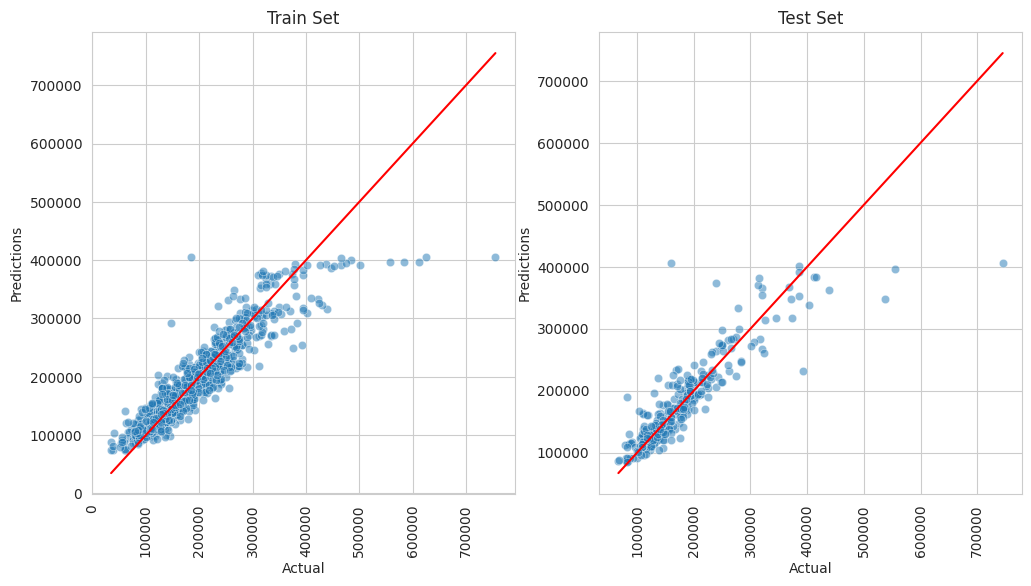

In [22]:
regression_performance(X_train, y_train, X_test, y_test,best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)


**The R2 score on the test set is 0.77, this means it passes the goal to perform above an R2 score of at least 0.75. This model is trained on 5 features.**

## **2. RandomForestRegressor**

In [23]:
best_model = grid_search_summary.iloc[45,0]
best_model

'RandomForestRegressor'

* Best model parameters

In [24]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 100}

* Best model pipeline

In [25]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('median_imputer',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'BsmtFinType1', 'GarageFinish',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.9)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0))),
                ('model',
                 RandomForestRegressor(min_samples_split=50, random_state=0))])

## Assess the Feature Importance

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


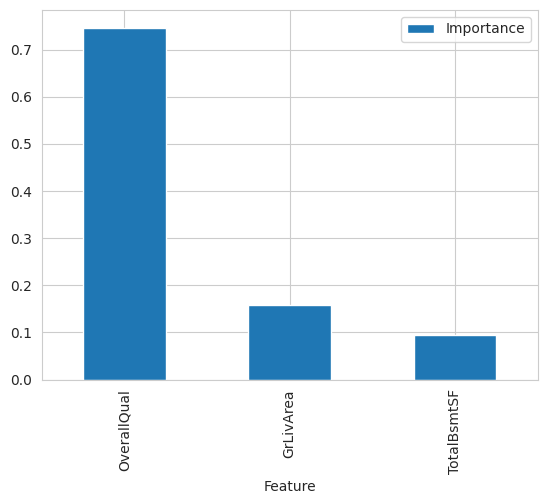

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Apply pipeline transformation to X_train
transformed_array = Pipeline(best_pipeline.steps[:4]).transform(X_train)

# Extract selected features correctly
selected_mask = best_pipeline['feat_selection'].get_support()
selected_features = [col for col, keep in zip(X_train.columns, selected_mask) if keep]

# Extract final selected features
best_features = selected_features

# Create DataFrame with selected feature importance
df_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the most important features
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot feature importance
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


### Evaluate Model Performance

Model Evaluation 

* Train Set
R2 Score: 0.826
Mean Absolute Error: 21605.1
Mean Squared Error: 1069068678.37
Root Mean Squared Error: 32696.616


* Test Set
R2 Score: 0.753
Mean Absolute Error: 23647.632
Mean Squared Error: 1707946097.874
Root Mean Squared Error: 41327.305




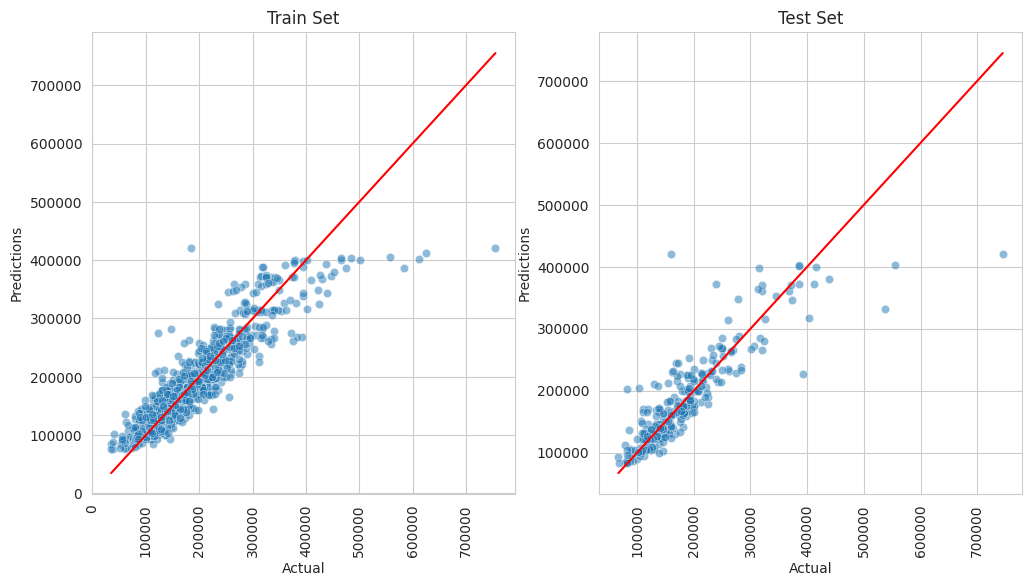

In [27]:
regression_performance(X_train, y_train, X_test, y_test,best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)


**The R2 score on the test set is 0.753, this means it passes the goal to perform above an R2 score of at least 0.75. This is a great result and may be the best model, however it may have trouble predicting price above £400,000**

## 3. GradientBoostingRegressor

In [28]:
best_model = grid_search_summary.iloc[7,0]
best_model

'GradientBoostingRegressor'

* Best model parameters

In [29]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

* Best model pipeline

In [30]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('median_imputer',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'BsmtFinType1', 'GarageFinish',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.9)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(min_samples_leaf=50,
                                           n_estimators=140, random_state=0))])

## Assess Feature Importance

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


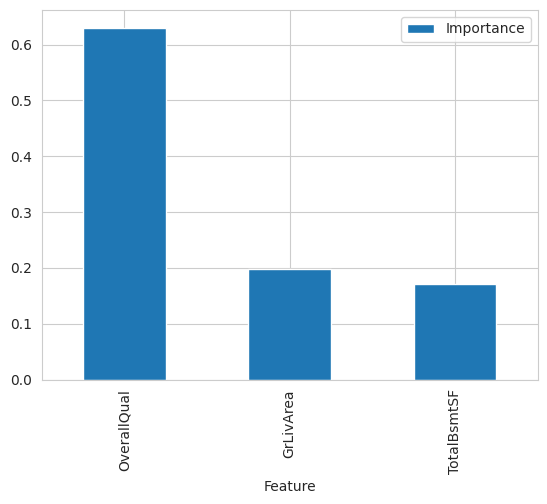

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Apply pipeline transformation to X_train
transformed_array = Pipeline(best_pipeline.steps[:4]).transform(X_train)

# Extract selected features correctly
selected_mask = best_pipeline['feat_selection'].get_support()
selected_features = [col for col, keep in zip(X_train.columns, selected_mask) if keep]

# Extract final selected features
best_features = selected_features

# Create DataFrame with selected feature importance
df_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the most important features
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot feature importance
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Model Performance

Model Evaluation 

* Train Set
R2 Score: 0.834
Mean Absolute Error: 21359.496
Mean Squared Error: 1024460750.793
Root Mean Squared Error: 32007.198


* Test Set
R2 Score: 0.761
Mean Absolute Error: 24327.455
Mean Squared Error: 1648795357.104
Root Mean Squared Error: 40605.361




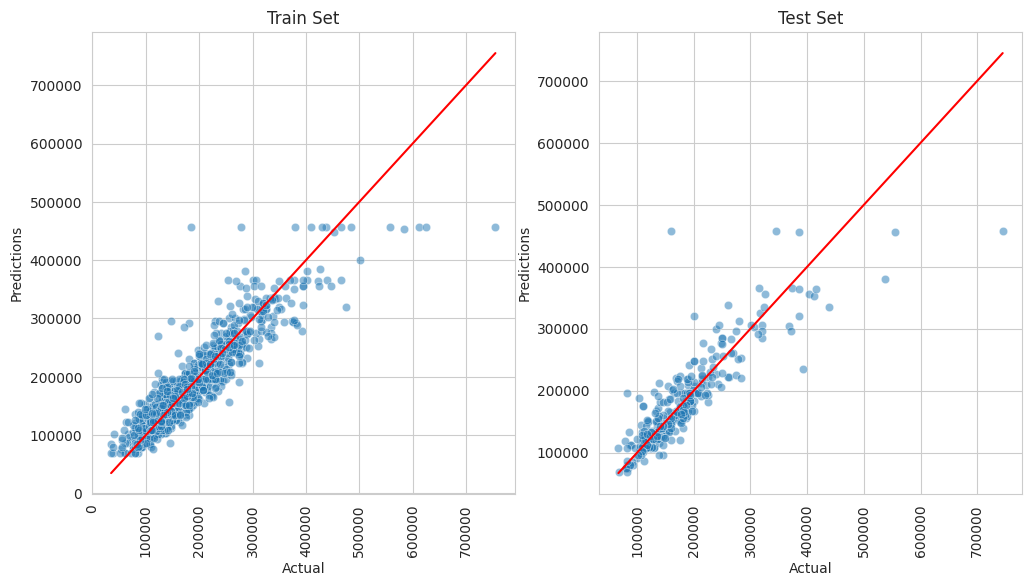

In [32]:
regression_performance(X_train, y_train, X_test, y_test,best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)

**The R2 score on the test set is 0.76. It passes the R2 performance requirement of 0.75 however the model is has not predicted any values above circa £450,000.**

## 4. LinearRegression

In [33]:
best_model = grid_search_summary.iloc[0,0]
best_model

'LinearRegression'

* Best model parameters

In [34]:
grid_search_pipelines[best_model].best_params_

{}

* Best model pipeline

In [35]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline


Pipeline(steps=[('median_imputer',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'BsmtFinType1', 'GarageFinish',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.9)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=LinearRegression())),
                ('model', LinearRegression())])

## Assess Feature Importance

LinearRegression has no feature importance so we can remove the df_feature_importance from this assessment

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Apply pipeline transformation to X_train
transformed_array = Pipeline(best_pipeline.steps[:4]).transform(X_train)

# Extract selected features correctly
selected_mask = best_pipeline['feat_selection'].get_support()
selected_features = [col for col, keep in zip(X_train.columns, selected_mask) if keep]


### Evaluate Model Performance

Model Evaluation 

* Train Set
R2 Score: 0.802
Mean Absolute Error: 23465.556
Mean Squared Error: 1217188113.569
Root Mean Squared Error: 34888.223


* Test Set
R2 Score: 0.641
Mean Absolute Error: 26790.057
Mean Squared Error: 2479265844.92
Root Mean Squared Error: 49792.227




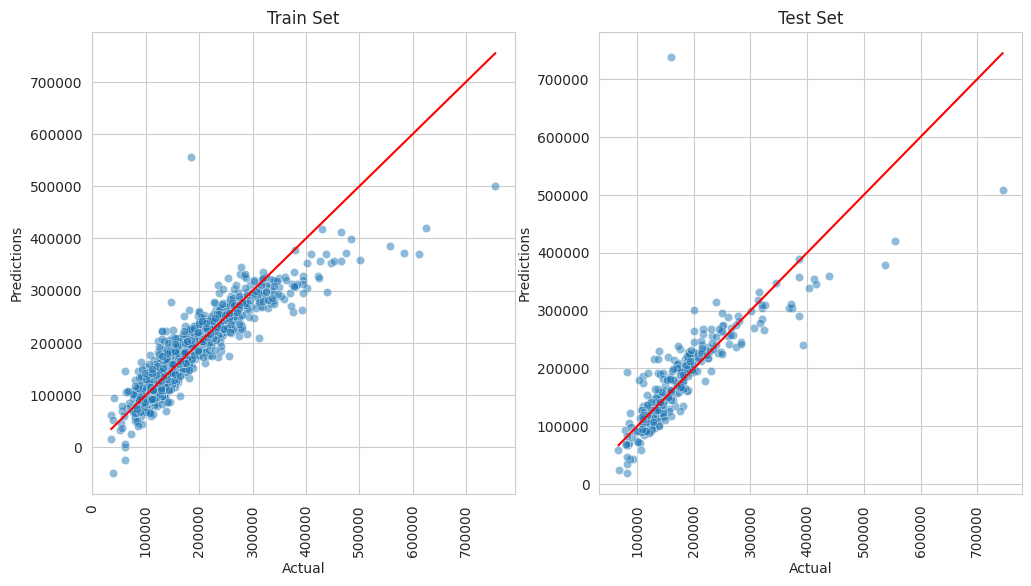

In [37]:
regression_performance(X_train, y_train, X_test, y_test,best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)

**The R2 score on the test set is 0.64. It does not pass the R2 performance requirement of 0.75.**

# Refit the pipeline with best features

**We chose to fit RandomForestRegressor**

In [38]:
best_model = grid_search_summary.iloc[45,0]
best_model

'RandomForestRegressor'

In [39]:
grid_search_pipelines[best_model].best_params_


{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 100}

In [40]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('median_imputer',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'BsmtFinType1', 'GarageFinish',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.9)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0))),
                ('model',
                 RandomForestRegressor(min_samples_split=50, random_state=0))])

## Assess Feature Importance

['GrLivArea', 'OverallQual', 'TotalBsmtSF']
* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


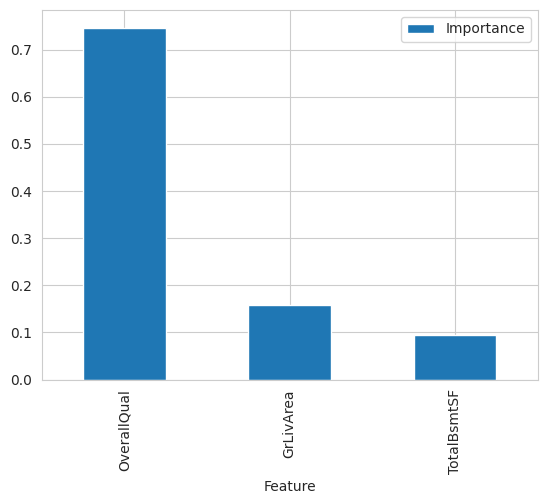

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Apply pipeline transformation to X_train
transformed_array = Pipeline(best_pipeline.steps[:4]).transform(X_train)

# Extract selected features correctly
selected_mask = best_pipeline['feat_selection'].get_support()
selected_features = [col for col, keep in zip(X_train.columns, selected_mask) if keep]

# Extract final selected features
best_features = selected_features
print(selected_features)
# Create DataFrame with selected feature importance
df_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the most important features
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot feature importance
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


**The RandomForestRegressor pipeline is only trained on 3 features out of the 23 so we updated the pipeline, training set and test set so that the model is smaller and can be more efficient when predicting sale price**

In [42]:
def PipelineOptimization(dic, vars_with_missing_data, model):
    
      pipeline = Pipeline([
            ("feat_scaling", StandardScaler()),
            ("model", RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2))
])


      return pipeline

## Update the Train Set and Test Set

In [43]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 3) (1168,) 
* Test set: (292, 3) (292,)


,GrLivArea,OverallQual,TotalBsmtSF
618,1828.0,9,1822.0
870,894.0,5,894.0
92,964.0,5,876.0


## Grid Search CV - SciKit Learn

In [44]:
models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor": {
        'model__n_estimators': [200, 300],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 5],
        'model__max_leaf_nodes': [None, 100]
    }
}


### Train the new models with GridSearchCV

In [45]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


### Show the Results

In [46]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
34,RandomForestRegressor,0.758995,0.808018,0.845125,0.034363,10,100,5,10,200
89,RandomForestRegressor,0.758029,0.807443,0.847657,0.035021,None,None,5,10,300
16,RandomForestRegressor,0.758813,0.807294,0.844524,0.035357,10,None,5,10,200
48,RandomForestRegressor,0.759145,0.807062,0.844797,0.034237,20,None,5,2,200
68,RandomForestRegressor,0.755386,0.806835,0.845616,0.03517,20,100,5,5,200
...,...,...,...,...,...,...,...,...,...,...
54,RandomForestRegressor,0.675882,0.776581,0.821618,0.057658,20,100,1,2,200
36,RandomForestRegressor,0.693974,0.776181,0.81373,0.047985,20,None,1,2,200
72,RandomForestRegressor,0.679503,0.775098,0.817516,0.052383,None,None,1,2,200
73,RandomForestRegressor,0.678083,0.771326,0.814306,0.053222,None,None,1,2,300


In [47]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

In [48]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline


Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=10, max_leaf_nodes=100,
                                       min_samples_leaf=5, min_samples_split=10,
                                       n_estimators=200))])

Model Evaluation 

* Train Set
R2 Score: 0.875
Mean Absolute Error: 18217.974
Mean Squared Error: 770961065.442
Root Mean Squared Error: 27766.186


* Test Set
R2 Score: 0.771
Mean Absolute Error: 22928.669
Mean Squared Error: 1580114925.793
Root Mean Squared Error: 39750.659




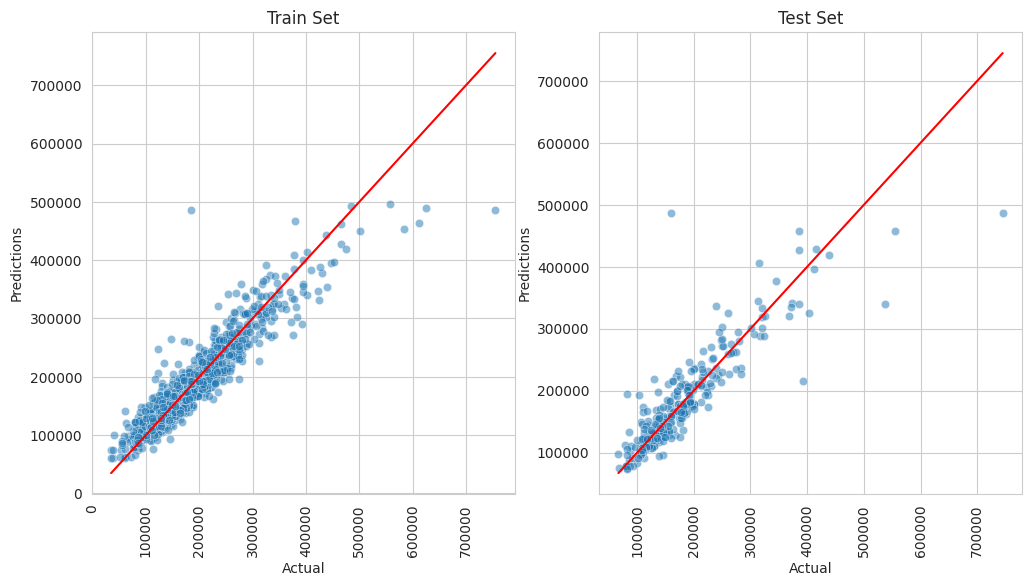

In [49]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)

### Save all the files neccassary from the notebook

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

#### Save Train Set:

In [ ]:
X_train.head()


In [57]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train.head()

In [59]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

#### Save Test Set:

In [ ]:
X_test.head()

In [61]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test.head()

In [63]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

#### Modeling Pipeline

In [ ]:
best_pipeline

In [ ]:
joblib.dump(value=best_pipeline, filename=f"{file_path}/best_pipeline.pkl")